In [1]:
import warnings
warnings.filterwarnings("ignore")

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
directory = "csvs/"
combinedFile = "csvs/combined_csv.csv"

combinedSpanFile = "csvs/combined_span_csv.csv"

# delete csv combined if it exists so it doesn't duplicate its contents
if os.path.exists(combinedSpanFile):
    os.remove(combinedSpanFile)
    
# delete csv combined if it exists so it doesn't duplicate its contents
if os.path.exists(combinedFile):
    os.remove(combinedFile)
    
for filename in os.listdir(directory):
    if filename.endswith(".csv"): 
        print(filename)
        df1 = pd.read_csv((directory+'/'+filename), delimiter='|', header=0, error_bad_lines=False)
        print('Number of titles: {:,}\n'.format(df1.shape[0]))
        continue

1984.csv
Number of titles: 11

1985.csv
Number of titles: 3

1986.csv
Number of titles: 15

1987.csv
Number of titles: 28

1989.csv
Number of titles: 11

1990.csv
Number of titles: 17

1991.csv
Number of titles: 26

1992.csv
Number of titles: 14

1993.csv
Number of titles: 26

1994.csv
Number of titles: 23

1995.csv
Number of titles: 42

1996.csv
Number of titles: 42

1997.csv
Number of titles: 43

1998.csv
Number of titles: 49

1999.csv
Number of titles: 63

2000.csv
Number of titles: 51

2001.csv
Number of titles: 88

2002.csv
Number of titles: 97

2003.csv
Number of titles: 91

2004.csv
Number of titles: 202

2005.csv
Number of titles: 144

2006.csv
Number of titles: 155

2007.csv
Number of titles: 102

2008.csv
Number of titles: 93

2009.csv
Number of titles: 89

2010.csv
Number of titles: 95

2011.csv
Number of titles: 98

2012.csv
Number of titles: 108

2013.csv
Number of titles: 214

2014.csv
Number of titles: 138

2015.csv
Number of titles: 151

2016.csv
Number of titles: 149



In [3]:
#os.chdir("..")
#print(os.getcwd())
#os.chdir("csv")
import glob
import pandas as pd
from os import listdir
from os.path import isfile, join

# delete csv combined if it exists so it doesn't duplicate its contents
if os.path.exists(combinedFile):
    os.remove(combinedFile)
    
extension = 'csv'

all_filenames = [f for f in listdir(directory) if isfile(join(directory, f))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv((directory+'/'+f), delimiter='|', error_bad_lines=False).replace({',': ' '}, regex=False) for f in all_filenames ])
#export to csv
combined_csv.to_csv(combinedFile, index=False,encoding='utf-8-sig')

df_years = pd.read_csv(combinedFile, delimiter=',', header=0, error_bad_lines=False)
print('Number of titles: {:,}\n'.format(df_years.shape[0]))
df_years.sample(10)

Number of titles: 2,973



,year,congress,title,abstract,link,tags
333,1998,15C3,securityz Emissionen und Empfangsmöglichkeiten,NaN,https://events.ccc.de/congress/1998/fahrplan-b...,NaN
1996,2013,30C3,Fukami: Acid Pauli!!,NaN,https://events.ccc.de/congress/2013/Fahrplan/s...,NaN
388,1999,16C3,SIGINT Technik Status Quo: Was wissen wir? Was...,(Kurzbeschreibung liegt noch nicht vor),https://events.ccc.de/congress/1999/fahrplan.html,NaN
135,1993,10C3,"Modacom ""wireless modem""",NaN,https://web.archive.org/web/20060521101447/htt...,NaN
1113,2006,23C3,A Probabilistic Trust Model for GnuPG: A new w...,Ein Vertrauensnetz beschreibt einen typischen ...,https://events.ccc.de/congress/2006/Fahrplan/s...,NaN
1929,2013,30C3,live! Gongkonzert Klanghaus Media Audionic,NaN,https://events.ccc.de/congress/2013/Fahrplan/s...,NaN
1410,2008,25C3,OnionCat – A Tor-based Anonymous VPN: Building...,OnionCat manages to build a complete IP transp...,https://events.ccc.de/congress/2008/Fahrplan/s...,NaN
1329,2007,24C3,securityz Nightmares 2008: Oder: worüber wir n...,securityz Nightmares - der jährliche Rückblick...,https://events.ccc.de/congress/2007/Fahrplan/s...,NaN
1122,2006,23C3,AVIT>C23: Vidvox VDMX5,"Rewritten from scratch as a Universal Binary, ...",https://events.ccc.de/congress/2006/Fahrplan/s...,NaN
2121,2014,31C3,Jahresrückblick des CCC: Der Protest gegen TTI...,Auch das Jahr 2014 geht irgendwann vorbei. Des...,https://events.ccc.de/congress/2014/Fahrplan/s...,NaN


In [4]:
import re

combinedSpanFile = "csvs/combined_span_csv.csv"

# delete csv combined if it exists so it doesn't duplicate its contents
if os.path.exists(combinedSpanFile):
    os.remove(combinedSpanFile)
    
with open(combinedFile, "rt", encoding="utf8") as fin:
    with open(combinedSpanFile, "wt", encoding="utf8") as fout:
        for line in fin:
            newString = re.sub("201\d{1}", "2010", line)
            newString = re.sub("200\d{1}", "2000", newString)
            newString = re.sub("198\d{1}", "1980", newString)
            newString = re.sub("199\d{1}", "1990", newString)
            fout.write(newString)

In [5]:
combinedSpanFile = "csvs/combined_span_csv.csv"

df_span = pd.read_csv(combinedSpanFile, delimiter=',', header=0, error_bad_lines=False)
print('Number of titles: {:,}\n'.format(df_span.shape[0]))
df_span.sample(10)


Number of titles: 2,973



,year,congress,title,abstract,link,tags
1846,2010,30C3,HbbTV securityz: A singing and dancing robot b...,HbbTV (Hybrid broadband broadcast TV) is an em...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1180,2000,23C3,hackz Jeopardy: The one and only hackz quizshow,"The well known quizshow format, but of course ...",https://events.ccc.de/congress/2000/Fahrplan/s...,NaN
172,1990,11C3,Visionen für die Infobahn: Digitale Städte und...,Vier Vertreter unterschiedlicher Projekte stel...,https://events.ccc.de/congress/1990/,NaN
2134,2010,31C3,EMET 5.1 - Armor or Curtain?: Politics and Phy...,EMET (Enhanced Mitigation Experience Toolkit) ...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1385,2000,25C3,Console hackz 2000: Wii Fail: Is implementatio...,The Nintendo Wii game console has been one of ...,https://events.ccc.de/congress/2000/Fahrplan/s...,NaN
215,1990,12C3,Machen Netzwerke Staaten überflüssig?,NaN,https://events.ccc.de/congress/1990/fahrplan.htm,NaN
2805,2010,35C3,Hacking how we see,"We mostly see with the mind, and the mind is f...",https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1734,2010,29C3,"Defend your Freedoms Online: It's Political, S...",Over the years we learned impressively how to ...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
2209,2010,32C3,PLC-Blaster: A deep dive into the surveillance...,Unser Vortrag demonstriert einen PLC-only Wurm...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1039,2000,22C3,Private Investigations - Opening Show and Keyn...,Introductory opening session by Tim Pritlove a...,http://events.ccc.de/congress/2000/fahrplan/ev...,NaN


Number of titles: 2,973

<class 'dict'>
Training/Testing Accuracy 	 SVM 	 0.9978165938864629 	 0.7137404580152672
Training/Testing Accuracy 	 NB 	 0.732532751091703 	 0.6335877862595419


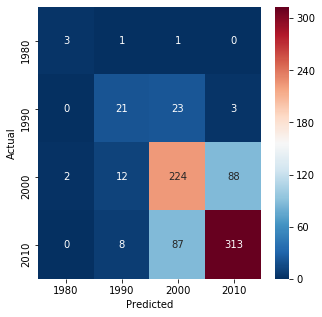

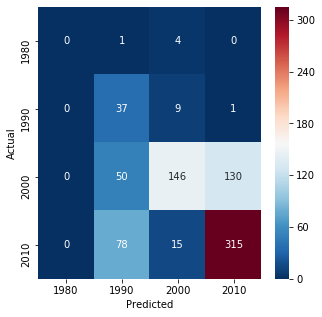

In [8]:
df = df_span

#print(os.getcwd())
plots = "plots"

import pandas as pd
import matplotlib.pyplot as plt

df.head()
print('Number of titles: {:,}\n'.format(df.shape[0]))

from io import StringIO
col = ['year', 'abstract']
df = df[col]
df = df[pd.notnull(df['abstract'])]
df.columns = ['year', 'abstract']

df['category_id'] = df['year'].factorize()[0]
category_id_df = df[['year', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(type(category_to_id))
id_to_category = dict(category_id_df[['category_id', 'year']].values)
df.head()


modelsArray = ["SVM","NB"]
for w in range(len(modelsArray)):
    model_type = modelsArray[w]
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer 
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from nltk import pos_tag
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from sklearn import svm
    from sklearn.linear_model import LogisticRegression

    X_train, X_test, y_train, y_test = train_test_split(df['abstract'], df['year'],random_state = 1, test_size=0.30)
    from nltk.corpus import stopwords
    #count_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words = stopwords.words("spanish"), sublinear_tf=True)#ngram size, default 1,1, default word ngrams
    count_vect = CountVectorizer(analyzer='word', ngram_range=(1, 1))#ngram size, default 1,1, default word ngrams
    count_vect.fit(X_train)       
    X_train_tfidf = count_vect.transform(X_train)
    X_train_tfidf = count_vect.fit_transform(X_train)
    X_test_tfidf = count_vect.transform(X_test)
    if model_type=="SVM":
        clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    if model_type=="NB":
        clf = MultinomialNB()
    if model_type=="LR":
        clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial', max_iter=4000)

    train_model=clf.fit(X_train_tfidf, y_train)
    test_accuracy=train_model.predict(X_test_tfidf)
    #print(test_accuracy)
    print("Training/Testing Accuracy" , '\t' , model_type , '\t' , train_model.score(X_train_tfidf, y_train) , '\t' , train_model.score(X_test_tfidf, y_test))

    #plot confusion matrices
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_test, test_accuracy)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',cmap="RdBu_r",
                xticklabels=category_id_df.year.values, yticklabels=category_id_df.year.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    #plt.show(block=False)
    pltFileName = plots+'/'+'combined'+'_'+model_type+'.pdf';
    plt.savefig(pltFileName)